In [1]:
import pickle
import json
import numpy as np
import nltk
import pandas as pd

In [2]:
# loading data
with open('results/predictions_all_layers.pkl', 'rb') as f:
    predictions = pickle.load(f)

with open('data/label_vocab.json', 'rb') as f:
    label_vocab = json.load(f)
    idx2label = {v: k for k, v in label_vocab.items()}

with open('data/span_ids.pkl', 'rb') as f:
    span_ids = pickle.load(f)

with open('results/results_f1_all_layers.pkl', 'rb') as f:
    results_f1 = pickle.load(f)

with open('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/corpora/eval_trees_10k.txt', 'r') as f:
    eval_trees = f.readlines()
    eval_trees = [nltk.Tree.fromstring(tree) for tree in eval_trees]

In [3]:
# list met predictions per layer
# predictions zijn tuple labels, predictions
# labels zijn list met labels
# predictions zijn list met tensor met predictions
predictions_final_layer = predictions[-1]
labels = predictions_final_layer[0]
predictions = predictions_final_layer[1]

In [4]:
def create_data_splits(data):
    corpus_size = len(data)
    train_split, dev_split, test_split = int(0.8 * corpus_size), int(0.9 * corpus_size), corpus_size

    train_data = data[:train_split]
    dev_data = data[train_split:dev_split]
    test_data = data[dev_split:test_split]

    return train_data, dev_data, test_data

In [12]:
_, _, test_spans = create_data_splits(span_ids)
_, _, test_trees = create_data_splits(eval_trees)
for check in [test_spans, test_trees]:
    assert len(check) == len(predictions), f"Length of test spans and predictions do not match: {len(check)} != {len(predictions)}"

In [13]:
print(span_ids[0])

tensor([[0, 9],
        [0, 8],
        [1, 8],
        [2, 8],
        [3, 8],
        [4, 5],
        [4, 8],
        [6, 8],
        [7, 8]])


In [17]:
def create_matrix(sentences, predictions, spans, label_vocab):
    """
    Creates a matrix filled with predictions per span from the predictions and the spans
    Span contains indices for which there is a prediction
    """
    all_results = []
    for i, (sent_pred, span) in enumerate(zip(predictions, spans)):
        sent_length = int(spans[i][0][1]) + 1
        result = np.chararray((sent_length, sent_length), itemsize=4, unicode=True)
        result[:] = 'xx'
        assert span.shape[0] == len(sent_pred), f"Length of predictions and spans do not match: {span.shape[0]} != {len(sent_pred)}"
        for j, (start, end) in enumerate(span):
            result[start, end] = label_vocab[sent_pred[j]]
            result_df = pd.DataFrame(result, columns=sentences[i].leaves())
        
        all_results.append(result_df)
        
    return all_results

In [18]:
test_chart = create_matrix(test_trees, predictions, test_spans, idx2label)
gold_chart = create_matrix(test_trees, labels, test_spans, idx2label)

In [19]:
for i, (gold, test) in enumerate(zip(gold_chart, test_chart)):
    print('gold', gold)
    print('test', test)
    if i == 10:
        break

gold   General Sven has craving him down again   .
0      xx   NP  xx      xx  xx   xx     S   S
1      xx   xx  xx      xx  xx   xx    xx  xx
2      xx   xx  xx      xx  xx   xx    VP  xx
3      xx   xx  xx      xx  VP   VP    VP  xx
4      xx   xx  xx      xx  xx   xx    xx  xx
5      xx   xx  xx      xx  xx   xx    xx  xx
6      xx   xx  xx      xx  xx   xx    xx  xx
7      xx   xx  xx      xx  xx   xx    xx  xx
test   General Sven has craving him down again   .
0      xx   NP  xx      xx  xx   xx     S   S
1      xx   xx  xx      xx  xx   xx    xx  xx
2      xx   xx  xx      xx  xx   xx    VP  xx
3      xx   xx  xx      xx  VP   VP    VP  xx
4      xx   xx  xx      xx  xx   xx    xx  xx
5      xx   xx  xx      xx  xx   xx    xx  xx
6      xx   xx  xx      xx  xx   xx    xx  xx
7      xx   xx  xx      xx  xx   xx    xx  xx
gold     ` She just were Beginning  to help   ? <apostrophe><apostrophe>
0  xx   S    S   xx        xx  xx    S   S                        S
1  xx  xx   xx   xx  

In [24]:
from collections import defaultdict

In [45]:
model = 'babyberta'
version = 'normal'
top_k = 0.2


top_k_per_laag_f1 = defaultdict(list)
for top_k in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    with open(f'results/{model}/{version}/{top_k}/results_f1_all_layers.pkl', 'rb') as f:
        predictions = pickle.load(f)

        for i, lpred in enumerate(predictions):
            top_k_per_laag_f1[top_k].append(lpred[-1])

with open('results/results_f1_all_layers.pkl', 'rb') as f:
    predictions = pickle.load(f)
    print(predictions)

    for i, lpred in enumerate(predictions):
        top_k_per_laag_f1[1.0].append(lpred[-1])

[(0.9198913145319966, 0.9198913145319966)]


In [42]:
top_k_per_laag_pred = defaultdict(list)
for top_k in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    with open(f'results/{model}/{version}/{top_k}/predictions_all_layers.pkl', 'rb') as f:
        predictions = pickle.load(f)
        for i, lpred in enumerate(predictions):
            top_k_per_laag_pred[top_k].append(lpred[1])

In [40]:
top_k_per_laag_pred

defaultdict(list,
            {0.3: [[[1, 1, 2, 2, 2, 2, 4, 3, 4],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 3],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 3, 3, 2, 2, 3, 4, 3, 4],
               [1, 1, 2, 2, 2, 2, 4, 3, 4, 2, 2, 3, 4, 3, 4],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 3, 3, 4],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 4, 3, 2, 2, 3, 4, 3, 4],
               [1, 1, 2, 2, 2, 4, 2, 2, 3, 4, 4, 3],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 2, 3, 4, 4, 3, 4],
               [1, 1, 2, 2, 2, 2, 3, 4, 3, 4],
               [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 3, 4],
               [1, 1, 2, 2, 2, 4, 2, 4, 4, 3],
               [1,
                1,
                1,
                1,
                1,
                1,
                1,
                2,
                2,
                2,
                2,
                2,
                2,
                4,
                3,
 

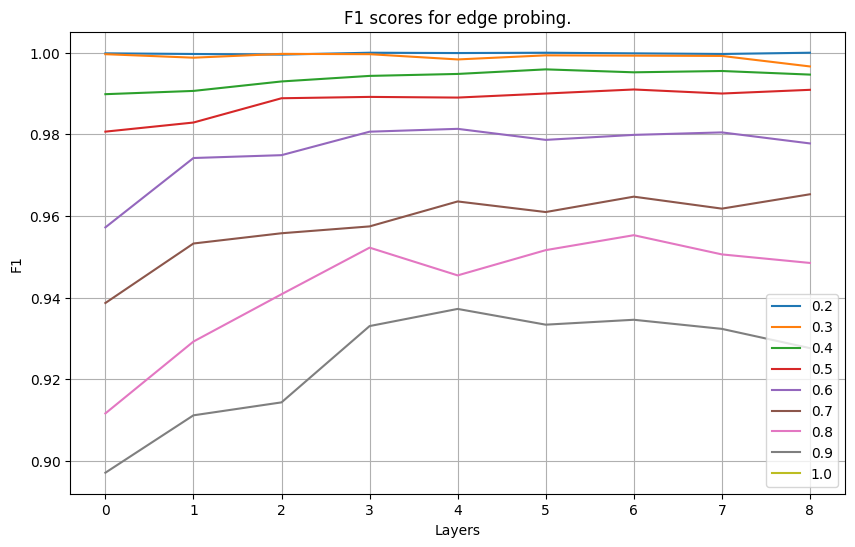

In [43]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Example defaultdict with lists of the same length
data = defaultdict(list)
data['x'] = [1, 2, 3, 4, 5]
data['y1'] = [2, 3, 5, 7, 11]
data['y2'] = [1, 4, 6, 8, 10]

# Function to plot defaultdict with lists
def plot_defaultdict(data):
    plt.figure(figsize=(10, 6))
    
    x_values = data
    for key in data:
        x_values = range(len(data[key]))
        plt.plot(x_values, data[key], label=key)

    plt.xlabel('Layers')
    plt.ylabel('F1')
    plt.title('F1 scores for edge probing.')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_defaultdict(top_k_per_laag_f1)